# Solutions - Vertical FL and Generative Modeling

## Question 1: Feature permutation in VFL (4 points)

Using the template code from [lab_vfl.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-vfl.ipynb), experiment with how shuffling the order of feature assignments to clients affects the performance. Use 4 clients with the default hyperparameters. Experiment with **5** random feature permutations and plot the training loss. Report whether shuffling features significantly affects the convergence rates and the reasoning behind it.

Scoring:
- _(1 point)_ Create 5 feature permutations with seeded Python/NumPy random functions and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) the permutations have on the loss and explain the observed pattern.

'Random' means random in 13 labels like this: \
Client feature names: ['age', 'sex', 'cp', 'trestbps', 'chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
from vfl import BottomModel, TopModel, VFLNetwork

torch.manual_seed(42)
np.random.seed(42)

In [2]:
class VFLNetworkModif(VFLNetwork):
    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, x, y):
        self.num_cli = n_cli  
        self.cli_features = cli_features  
        x = x.astype('float32')
        y = y.astype('float32')
        # devide dataset by cli_features, they are not equal due to one-hot label
        x_train = [torch.tensor(x[feats].values) for feats in cli_features]
        y_train = torch.tensor(y.values)
        num_batches = len(x) // batch_sz if len(x) % batch_sz == 0 else len(x) // batch_sz + 1
        train_loss = []
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            correct = 0.0
            total = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    x_minibatch = [x[int(minibatch * batch_sz):] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):]
                else:
                    x_minibatch = [x[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)]
                outs = self.forward(x_minibatch)
                pred = torch.argmax(outs, dim=1)
                actual = torch.argmax(y_minibatch, dim=1)
                correct += torch.sum((pred == actual))
                total += len(actual)
                loss = self.criterion(outs, y_minibatch)
                total_loss += loss
                loss.backward()
                self.optimizer.step()
            train_loss.append(total_loss.detach())
            if epoch%100 == 0:
                print(f"Epoch: {epoch} Train accuracy: {correct * 100 / total:.2f}% Loss: {total_loss.detach().numpy()/num_batches:.3f}")
        return train_loss

In [3]:
def preprocess_data(seed = None, num_clients = 4, random_shuffle = False, file_path = "heart-dataset/heart.csv"):    
    df = pd.read_csv(file_path)
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])  # scale numerical features for effective learning
    encoded_df = pd.get_dummies(df, columns=categorical_cols)  #convert categorical features to one-hot embeddings
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[['target']], columns=['target'])
    
    # decide how many features each client can have here
    features_per_client = (num_clients - 1) * [(len(df.columns) - 1) // num_clients]  # "equally" partition the features
    features_per_client.append(len(df.columns) - 1 - sum(features_per_client))
    features_per_client = np.array(features_per_client)
    
    all_feature_names = list(df.columns)
    all_feature_names.pop()
    client_feature_names = []
    csum_features_per_client = np.cumsum(features_per_client)
    encoded_df_feature_names = list(X.columns)
    start_index = 0
    remaining_features = all_feature_names.copy()

    for num_feats in features_per_client:
        # decide select which feature here, use seed, do shuffling
        if random_shuffle:
            random.seed(seed)
            feat_names = random.sample(remaining_features, num_feats)
            remaining_features = [feat for feat in remaining_features if feat not in feat_names]
        else:
            feat_names = all_feature_names[start_index:start_index + num_feats]
            start_index = start_index + num_feats
        client_feature_names.append(feat_names)

    for i in range(len(client_feature_names)):
        updated_names = []
        for column_name in client_feature_names[i]:
            if column_name not in categorical_cols:
                updated_names.append(column_name)
            else:
                for name in encoded_df_feature_names:
                    # there is _ in label feature after one-hot embeddings
                    if '_' in name and column_name in name:
                        updated_names.append(name)
        client_feature_names[i] = updated_names
        
    return X, Y, client_feature_names, features_per_client

In [4]:
def model_initial(client_feature_names):
    # model architecture hyperparameters
    outs_per_client = 2 # 2 * in_channel
    bottom_models = [BottomModel(len(in_feats), outs_per_client * len(in_feats)) for in_feats in client_feature_names]
    final_out_dims = 2 # just true or false for classification
    Network = VFLNetworkModif(bottom_models, final_out_dims)
    return Network

In [5]:
def train_test(X, Y, Network, client_feature_names, num_clients = 4, EPOCHS = 300, BATCH_SIZE = 64, TRAIN_TEST_THRESH = 0.8):
    X_train, X_test = X.loc[:int(TRAIN_TEST_THRESH * len(X))], X.loc[int(TRAIN_TEST_THRESH * len(X)) + 1:]
    Y_train, Y_test = Y.loc[:int(TRAIN_TEST_THRESH * len(Y))], Y.loc[int(TRAIN_TEST_THRESH * len(Y)) + 1:]
    train_loss = Network.train_with_settings(EPOCHS, BATCH_SIZE, num_clients,
                                client_feature_names, X_train, Y_train)
    accuracy, loss = Network.test(X_test, Y_test)
    print(f"Test accuracy: {accuracy * 100:.2f}%")
    return train_loss

In [6]:
def loss_visualize_Q1(loss, random_shuffling, seed):
    for i, l in enumerate(loss):
        plt.plot(l, label=f'Experiment {i+1} - Shuffle: {random_shuffling[i]} - Seed: {seed[i]}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Convergence rates per Experiment')
    plt.legend()
    plt.show()

In [7]:
def Question_1():
    seed = [7, 42, 3407, 20011005, 20001114]
    random_shuffling = [True, True, True, True, True]
    loss = []
    for index in range(len(random_shuffling)):
        print(f"----------------Random shuffle: {random_shuffling[index]}----------------")
        X, Y, client_feature_names, _ = preprocess_data(seed = seed[index], random_shuffle = random_shuffling[index])
        print(f"Client feature names: {client_feature_names}")
        Network = model_initial(client_feature_names)
        train_loss = train_test(X, Y, Network, client_feature_names)
        loss.append(train_loss)
    loss_visualize_Q1(loss, random_shuffling, seed)

----------------Random shuffle: True----------------
Client feature names: [['fbs_0', 'fbs_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1', 'restecg_2'], ['exang_0', 'exang_1', 'trestbps', 'oldpeak'], ['chol', 'sex_0', 'sex_1', 'thalach'], ['ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'age', 'slope_0', 'slope_1', 'slope_2', 'thal_0', 'thal_1', 'thal_2', 'thal_3']]
Epoch: 0 Train accuracy: 49.57% Loss: 0.693
Epoch: 100 Train accuracy: 85.87% Loss: 0.369
Epoch: 200 Train accuracy: 91.96% Loss: 0.233
Test accuracy: 91.67%
----------------Random shuffle: True----------------
Client feature names: [['slope_0', 'slope_1', 'slope_2', 'sex_0', 'sex_1', 'age'], ['trestbps', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1', 'restecg_2'], ['ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'chol', 'thal_0', 'thal_1', 'thal_2', 'thal_3'], ['fbs_0', 'fbs_1', 'oldpeak', 'thalach', 'exang_0', 'exang_1']]
Epoch: 0 Train accuracy: 54.32% Loss: 0.685
Epoch: 100 Train accuracy: 82.22% Loss: 0.409
Ep

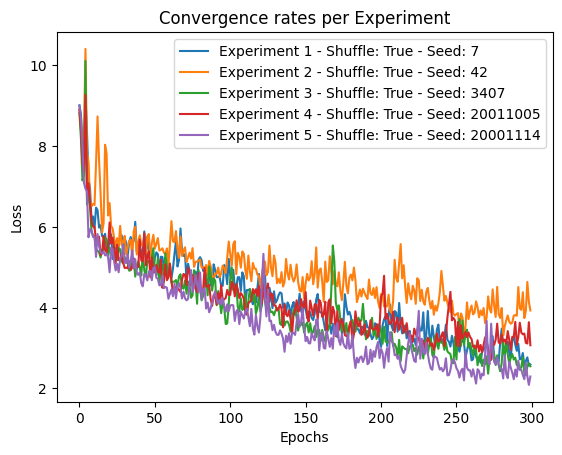

In [8]:
Question_1()

- _(2 points)_ State what impact (if any) the permutations have on the loss and explain the observed pattern.

> In general, shuffling does change the training loss curve, albeit not very significantly in this scenario. We do see that the losses more or less converge around the same region, so it appears that in this case, the model is still robust to permutations. However, it may be the case that in some special settings, such as assigning one client all the "important" features may yield a lower accuracy.  

## Question 2: Scaling clients in VFL (4 points)

With the same template code, experiment with how increasing the number of clients affects model performance. Plot the training loss with 2, 4, and 8 clients. Try a best-effort equal partitioning for the features, with the remaining extra features assigned to the last client. For example, with 14 features and three clients, assign four features to clients 1 and 2 and six to client 3. Report your reasoning for the observed output.

Scoring:
- _(1 point)_ Create the greedy feature splits for the requested client counts (use the default ordering in the dataset) and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.

In [9]:
def loss_visualize_Q2(loss, num_clients, features_per_client_list):
    for i, l in enumerate(loss):
        plt.plot(l, label=f'Clients: {num_clients[i]} - Features per client: {features_per_client_list[i]}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Convergence rates per Experiment')
    plt.legend()
    plt.show()

In [10]:
def Question_2(num_clients, loss, features_per_client_list):

    for index in range(len(num_clients)):
        print(f"----------------Clients: {num_clients[index]}----------------")
        X, Y, client_feature_names, features_per_client = preprocess_data(num_clients = num_clients[index])
        print('features_per_client: ', features_per_client)
        features_per_client_list.append(features_per_client)
        Network = model_initial(client_feature_names)
        train_loss = train_test(X, Y, Network, client_feature_names, num_clients = num_clients[index])
        loss.append(train_loss)
    
    return loss, features_per_client_list

In [11]:
loss = []
features_per_client_list = []
num_clients = [1, 2, 4, 8]
loss, features_per_client_list = Question_2(num_clients, loss, features_per_client_list)

----------------Clients: 1----------------
features_per_client:  [13]
Epoch: 0 Train accuracy: 61.39% Loss: 0.682
Epoch: 100 Train accuracy: 90.74% Loss: 0.267
Epoch: 200 Train accuracy: 91.11% Loss: 0.236
Test accuracy: 88.24%
----------------Clients: 2----------------
features_per_client:  [6 7]
Epoch: 0 Train accuracy: 49.70% Loss: 0.688
Epoch: 100 Train accuracy: 88.67% Loss: 0.300
Epoch: 200 Train accuracy: 92.69% Loss: 0.203
Test accuracy: 87.75%
----------------Clients: 4----------------
features_per_client:  [3 3 3 4]
Epoch: 0 Train accuracy: 48.23% Loss: 0.693
Epoch: 100 Train accuracy: 81.12% Loss: 0.400
Epoch: 200 Train accuracy: 87.09% Loss: 0.305
Test accuracy: 85.29%
----------------Clients: 8----------------
features_per_client:  [1 1 1 1 1 1 1 6]
Epoch: 0 Train accuracy: 48.60% Loss: 0.693
Epoch: 100 Train accuracy: 84.65% Loss: 0.395
Epoch: 200 Train accuracy: 85.75% Loss: 0.355
Test accuracy: 83.82%


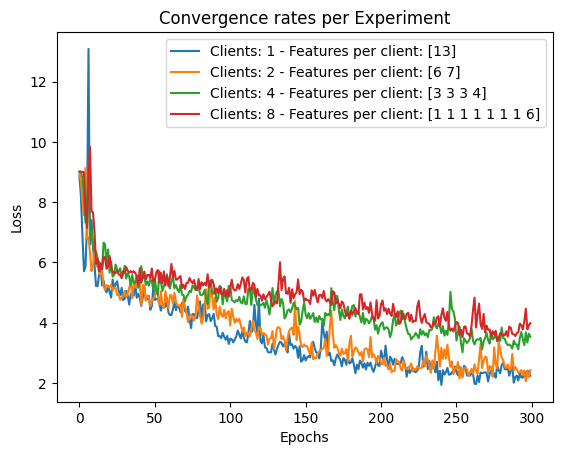

In [12]:
loss_visualize_Q2(loss, num_clients, features_per_client_list)

- _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.

> In general, adding more clients leads to a decrease in model performance. Intuitively, centralizing all the features at a single client (blue line) is expected to perform the best since it allows the model to capture dependencies while considering the influence of all features simultaneously. Increasing the number of clients leaves each one with a subset of features, so the extrapolated knowledge from the bottom models is limited to the influence sphere of the locally available features. Centralizing the forward activations still mitigates this somewhat by allowing the server to capture dependencies. But this still does not perform as well as centralizing the features right at the beginning. 

## Question 3: Bridging VFL and generative modeling (8 points)

In this exercise, you'll explore how synthetic data can be generated when the data is constrained to be vertically partitioned. In this regard, combine VFL with variational autoencoders (VAEs) by following the architecture shown in the figure below. Each client uses a local network, i.e., a multi-layer perceptron (MLP) to embed its sensitive features into latents. These latents are concatenated at the server and passed through a VAE. The VAE produces synthetic latents which are partitioned and then converted back into the actual input space using another MLP. Code the necessary components using the templates from [lab-vfl.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-vfl.ipynb) and [generative_modeling.py](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/generative_modeling.py). Show the model's training progress per epoch. 

Scoring:
- _(1 point)_ Preprocess the dataset and partition the features similarly to the discriminative model VFL lab.
- _(2 points)_ Define the input & output MLP networks to be used by clients.
- _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.
- _(2 points)_ Define the VFL network that fits together the client networks and that of the server.
- _(1 point)_ Create and run the training loop of the complete model, printing the loss at every epoch.

![vflvae.png](vflvae.png)

#### The first one is two MLP + VAE

In [13]:
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from centralized import HeartDiseaseNN as EvaluatorModel

torch.manual_seed(42)
np.random.seed(42)

class MLP_BottomModel(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(MLP_BottomModel, self).__init__()
        self.bottom_channel = out_channel
        self.linear1 = nn.Linear(in_channel, out_channel)
        self.lin_bn1 = nn.BatchNorm1d(num_features=out_channel)
        self.linear2 = nn.Linear(out_channel, out_channel)
        self.lin_bn2 = nn.BatchNorm1d(num_features=out_channel)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.lin_bn1(self.linear1(x)))
        x = self.relu(self.lin_bn2(self.linear2(x)))
        x = self.dropout(x)
        return x

In [14]:
class VAE_TopModel(nn.Module):
    def __init__(self, D_in, H=64, H2=48, latent_dim=32):

        # Encoder
        super(VAE_TopModel, self).__init__()
        self.optimizer = None
        self.criterion = None
        self.linear1 = nn.Linear(D_in, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)

        # Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))
        fc1 = F.relu(self.bn1(self.fc1(lin3)))
        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))

    def forward(self, x, output_sizes):
        concat_outs = torch.cat(x, dim=1)
        mu, logvar = self.encode(concat_outs)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        # split latent features
        split_outs = torch.split(z, output_sizes, dim=1)
        return split_outs, mu, logvar

    def sample(self, nr_samples, mu, logvar):
        sigma = torch.exp(logvar / 2)
        no_samples = nr_samples
        q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
        z = q.rsample(sample_shape=torch.Size([no_samples]))
        with torch.no_grad():
            pred = self.decode(z).cpu().numpy()
        pred[:, -1] = np.clip(pred[:, -1], 0, 1)
        pred[:, -1] = np.round(pred[:, -1])
        return pred
    
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        # Kullback-Leibler (KL) 
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [15]:
class VAE_VFLNetwork(nn.Module):
    def __init__(self, in_bottom_model, out_bottom_model):
        super(VAE_VFLNetwork, self).__init__()
        self.num_cli = None
        self.cli_features = None
        self.in_bottom_model = in_bottom_model
        self.out_bottom_model = out_bottom_model
        self.in_channel_cat = sum([in_bottom_model[i].bottom_channel for i in range(len(in_bottom_model))])
        self.out_channels = [in_bottom_model[i].bottom_channel for i in range(len(in_bottom_model))]
        self.top_model = VAE_TopModel(self.in_channel_cat)

    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, real_data, optimizer, loss_fn):
        self.n_cli = n_cli
        self.cli_features = cli_features
        self.optimizer = optimizer
        self.criterion = loss_fn
        num_batches = (len(real_data) // batch_sz if len(real_data) % batch_sz == 0 else len(real_data) // batch_sz + 1)
        print('cli_features: ', cli_features)
        real_data = [real_data[:, feats[0] : feats[0] + len(feats)] for feats in cli_features]
        loss_list = []
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    minibatch_data = [r_data[int(minibatch * batch_sz) :] for r_data in real_data]
                else:
                    minibatch_data = [r_data[int(minibatch * batch_sz) : int((minibatch + 1) * batch_sz)] for r_data in real_data]

                outs, mu, logvar = self.forward(minibatch_data)
                outs = torch.cat(outs, dim=1)
                minibatch_data = torch.cat(minibatch_data, dim=1)
                loss = self.criterion(outs, minibatch_data, mu, logvar)
                total_loss += loss
                loss.backward()
                self.optimizer.step()

            loss_list.append(total_loss.detach().numpy() / num_batches)
            print(f"Epoch: {epoch} Loss: {total_loss.detach().numpy() / num_batches:.3f}")

        return loss_list

    def forward(self, x):
        local_outs = [self.in_bottom_model[i](x[i]) for i in range(len(self.in_bottom_model))]
        vae_outs, mu, logvar = self.top_model(local_outs, self.out_channels)
        result = [self.out_bottom_model[i](vae_outs[i]) for i in range(len(self.out_bottom_model))]
        return result, mu, logvar

In [16]:
torch.manual_seed(42)
np.random.seed(42)

def data_process():
    df = pd.read_csv("heart-dataset/heart.csv")
    categorical = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
    encoded_df = pd.get_dummies(df, columns=categorical)
    X = encoded_df.drop("target", axis=1)
    y = encoded_df["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_train = torch.tensor(X_train).float()
    X_test = torch.tensor(X_test).float()
    y_train = torch.tensor(y_train.values).long()
    y_test = torch.tensor(y_test.values).long()
    real_data = torch.concat((X_train, y_train.view(-1, 1)), dim=1)
    return real_data

def data_split(real_data, num_clients = 3):
    features_per_client = (num_clients - 1) * [real_data.shape[1] // num_clients]
    features_per_client.append(real_data.shape[1] - sum(features_per_client))
    features_per_client = np.array(features_per_client)
    all_feature_names = np.array(range(real_data.shape[1]))
    client_feature_names = []
    start_index = 0
    for num_feats in features_per_client:
        feat_names = all_feature_names[start_index : start_index + num_feats]
        client_feature_names.append(feat_names)
        start_index = start_index + num_feats
    return client_feature_names

def model_initial(client_feature_names):
    size_scale = 2
    in_bottom_model = [MLP_BottomModel(len(in_feats), size_scale * len(in_feats))for in_feats in client_feature_names]
    out_bottom_model = [MLP_BottomModel(size_scale * len(in_feats), len(in_feats)) for in_feats in client_feature_names]
    return in_bottom_model, out_bottom_model

def TwoMLP_VAE(in_bottom_model, out_bottom_model, client_feature_names, real_data, n_cli):
    Network = VAE_VFLNetwork(in_bottom_model, out_bottom_model)
    EPOCHS = 300
    BATCH_SIZE = 64
    optimizer = optim.Adam(Network.parameters(), lr=1e-3)
    loss_mse = customLoss()
    loss = Network.train_with_settings(EPOCHS, BATCH_SIZE, n_cli, client_feature_names, real_data, optimizer, loss_mse)
    return loss

def loss_visualize_2MLP_VAE(loss, num_clients):
    for i, l in enumerate(loss):
        plt.plot(l, label=f'Clients: {num_clients}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Convergence rates per Experiment')
    plt.legend()
    plt.show()

In [ ]:
real_data = data_process()
num_clients = 3
client_feature_names = data_split(real_data, num_clients)
in_bottom_model, out_bottom_model = model_initial(client_feature_names)
loss = [TwoMLP_VAE(in_bottom_model, out_bottom_model, client_feature_names, real_data, num_clients)]
loss_visualize_2MLP_VAE(loss, num_clients)

cli_features:  [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])]
Epoch: 0 Loss: 3253.435
Epoch: 1 Loss: 3098.751
Epoch: 2 Loss: 2931.147
Epoch: 3 Loss: 2820.315
Epoch: 4 Loss: 2710.064
Epoch: 5 Loss: 2686.443
Epoch: 6 Loss: 2609.668
Epoch: 7 Loss: 2534.128
Epoch: 8 Loss: 2523.241
Epoch: 9 Loss: 2454.990
Epoch: 10 Loss: 2419.070
Epoch: 11 Loss: 2381.054
Epoch: 12 Loss: 2374.198
Epoch: 13 Loss: 2354.906
Epoch: 14 Loss: 2302.695
Epoch: 15 Loss: 2272.836
Epoch: 16 Loss: 2296.886
Epoch: 17 Loss: 2250.480
Epoch: 18 Loss: 2249.872
Epoch: 19 Loss: 2244.386
Epoch: 20 Loss: 2230.345
Epoch: 21 Loss: 2224.561
Epoch: 22 Loss: 2209.182
Epoch: 23 Loss: 2203.488
Epoch: 24 Loss: 2224.877
Epoch: 25 Loss: 2203.319
Epoch: 26 Loss: 2231.456
Epoch: 27 Loss: 2187.803
Epoch: 28 Loss: 2187.942
Epoch: 29 Loss: 2186.729
Epoch: 30 Loss: 2203.438
Epoch: 31 Loss: 2228.430
Epoch: 32 Loss: 2196.295
Epoch: 33 Loss: 2176.649
Epo